# Suffolk Snow Day?

I was asked to [talk](https://docs.google.com/presentation/d/1Kknr2pmhomVRHV1-6bJG2pGfJytQqGJ3o8FL_yGqp9s/edit?usp=sharing) to a group of law students and to put together a hands-on activity to give them a feel for what I do as a data scientist. So I came up with this grossly simplified workflow for answering that age-old question, "Can we predict if the law school will call a snow day?"

How? That's simple, **statistics**, or as many like to call it these days, AI/machine learning. So let's get going.

## Load Some Stuff

To run this code, [download, install, and run Notebooks](https://github.com/colarusso/measured_justice#download-install-and-run-notebooks). After that, [download](https://github.com/colarusso/regression_demo/archive/master.zip) and unzip this project. FYI, you'll have to load a few modules. So you may want to check out these [notes](https://github.com/colarusso/measured_justice#common-speed-bumps) on common speed bumps. Anyhow, the following code loads the tools we need.

In [1]:
import os
try:
    inputFunc = raw_input
except NameError:
    inputFunc = input

import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
import numpy as np
  
#import urllib.request
from urllib.request import urlopen
import re 
import json    

from sklearn.linear_model import LogisticRegression
from patsy import dmatrices
from sklearn.cross_validation import cross_val_score

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

C:\Users\dcolarusso\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def evaluate(pred, labels_test):
    acc = accuracy_score(pred, labels_test)
    print ("Accuracey: %s"%acc)
    tn, fp, fn, tp = confusion_matrix(labels_test, pred).ravel()

    recall = tp / (tp + fp)
    percision = tp / (tp + fn)
    f1 = (2 / ((1/recall)+(1/percision)))

    print ("")
    print ("True Negatives: %s"%tn)
    print ("False Positives: %s"%fp)
    print ("False Negatives: %s"%fn)
    print ("True Positives: %s"%tp)
    print ("Recall: %s"%recall)
    print ("Precision: %s"%percision)
    print ("F1 Score: %s"%f1)

## Data Collection

We want to build a model that will take in some data and spit out a prediction. So we'll need some training data. Specificly, if we think snow closures are based on weather conditions we'll need information on closings and weather conditions. Remember more is better. We want as much data as possible. So let's see what we can find.

### Closing Info

I wanted at least 5 years of data, and I was at a loss until I noticed that the Suffolk University Twitter account had been around for that long. So I did a little search for [@Suffolk_U tweets containg the word "closed."](https://twitter.com/search?src=typd&q=closed%20from%3ASuffolk_U) From here I constructed a list of closure, and place them into a spreadsheet with the following columns: `date`, `closed`, and `note`. 


### Weather Info

So we need a historic record of Boston's weather. Luckily, there are a lot of places to find this information. I'm going to use the [Dark Sky API](https://darksky.net/dev/account). An API is an interface that allows a computer program to get structured data on-demand. For example, a program visiting `https://api.darksky.net/forecast/[API_KEY]/42.3605,-71.0596,1314849600` will get a [structured reply](https://darksky.net/dev/docs/time-machine) that it can parse for info. 

The following blocks of code will make use of the DarkSky API to get historical weather data for Boston for school years 2011/2012 through most of 2016/2017.

In [ ]:
# When you sign up for API acces, you'll get a KEY. 
# This will prompt you for that key.

os.environ['KEY'] = inputFunc('What is your Dark Sky key? ')

In [ ]:
# This function will take a list of school days (SY), find the weather on those days,
# and place them into a dataframe (df)

def run_days():
    global SY
    global df
    for d in SY:
        #print (d)
        url_1 = "https://api.darksky.net/forecast/"+os.environ['KEY']+"/42.3605,-71.0596,"+str(round(d.timestamp()))
        jsonurl = urlopen(url_1)
        output = json.loads(jsonurl.read().decode("utf-8"))
        date = d
        try:
            accum = output["daily"]["data"][0]["precipAccumulation"]
        except KeyError:
            accum = 0  
        temp_min =(output["daily"]["data"][0]["temperatureMin"])
        temp_max = (output["daily"]["data"][0]["temperatureMax"])
        wind = (output["daily"]["data"][0]["windSpeed"])
        df = df.append({'date':date,'accum':accum,'temp_min':temp_min,'temp_max':temp_max,"wind":wind}, ignore_index=True)

# Create empty dataframe (df)        
df = pd.DataFrame([], columns=["date","accum","temp_min","temp_max","wind"])
# Get a set of rules defining bussiness/school days
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

# NOTE: I didn't do a very careful job of defining the school years 
# because I didn't have copies of the academic calendars for most 
# years at hand. I really should exclude spring break and the like.
# Right now, I'm hoping that I can skip this as there probably aren't
# many spring break snow days. ;)

# Get weather for Winter 2011 and add to df.
SY = pd.DatetimeIndex(start='2011-09-01',end='2011-12-20', freq=us_bd)
run_days()
# Get weather for Spring 2012 and add to df.
SY = pd.DatetimeIndex(start='2012-01-15',end='2012-05-20', freq=us_bd)
run_days()

# Get weather for Winter 2012 and add to df.
SY = pd.DatetimeIndex(start='2012-09-01',end='2012-12-20', freq=us_bd)
run_days()
# Get weather for Spring 2013 and add to df.
SY = pd.DatetimeIndex(start='2013-01-15',end='2013-05-20', freq=us_bd)
run_days()

# Get weather for Winter 2013 and add to df.
SY = pd.DatetimeIndex(start='2013-09-01',end='2013-12-20', freq=us_bd)
run_days()
# Get weather for Spring 2014 and add to df.
SY = pd.DatetimeIndex(start='2014-01-15',end='2014-05-20', freq=us_bd)
run_days()

# Get weather for Winter 2014 and add to df.
SY = pd.DatetimeIndex(start='2014-09-01',end='2014-12-20', freq=us_bd)
run_days()
# Get weather for Spring 2015 and add to df.
SY = pd.DatetimeIndex(start='2015-01-15',end='2015-05-20', freq=us_bd)
run_days()

# Get weather for Winter 2015 and add to df.
SY = pd.DatetimeIndex(start='2015-09-01',end='2015-12-20', freq=us_bd)
run_days()
# Get weather for Spring 2016 and add to df.
SY = pd.DatetimeIndex(start='2016-01-15',end='2016-05-20', freq=us_bd)
run_days()

# Get weather for Winter 2016 and add to df.
SY = pd.DatetimeIndex(start='2016-09-01',end='2016-12-20', freq=us_bd)
run_days()
# Get weather for Spring 2017 and add to df.
SY = pd.DatetimeIndex(start='2017-01-15',end='2017-04-07', freq=us_bd)
run_days()

df.to_csv('weatherdata.csv',index=False) # Write results to file.
df.head() # Give us a peek at the data.

## Data Cleaning

Here we load the data we collected above and get it all ready to feed to our statistical model. This is particuarly useful as I'm not going to give you my API key. So you don't have to get the weather data again.

In [3]:
# Load and peek at weather data
weather_df = pd.read_csv('weatherdata.csv', parse_dates=[0])
weather_df.head()

,date,accum,temp_min,temp_max,wind
0,2011-09-01,0.0,62.45,70.80,5.64
1,2011-09-02,0.0,60.21,67.46,4.80
2,2011-09-06,0.0,59.26,73.83,4.97
3,2011-09-07,0.0,59.72,61.98,9.91
4,2011-09-08,0.0,58.36,65.14,6.01


In [4]:
# Load and peek at closing data
snow_df = pd.read_csv('snowclosings.csv', parse_dates=[0])
snow_df = snow_df.fillna('')
#snow_df = snow_df[(snow_df["note"]=="") | 
#                  (snow_df["note"]=="email") | 
#                  (snow_df["note"]=="facebook")] # exclude entires with notes
snow_df.head()

,date,closed,note
0,2011-02-02,1,
1,2012-10-29,1,hurricane
2,2013-02-08,1,
3,2013-02-09,1,
4,2013-02-10,1,


In [5]:
# Merge weather and closing data into a single table
joint_df = weather_df.merge(snow_df, on='date', how='left')
joint_df["note"] = joint_df["note"].fillna('')
joint_df["closed"] = joint_df["closed"].fillna(0)
joint_df["past"] = joint_df["closed"].rolling(60).sum()
joint_df["past"] = joint_df["past"].fillna(0)
joint_df.to_csv('jointdata.csv',index=False) # Write results to file.
joint_df.head()

,date,accum,temp_min,temp_max,wind,closed,note,past
0,2011-09-01,0.0,62.45,70.80,5.64,0.0,,0.0
1,2011-09-02,0.0,60.21,67.46,4.80,0.0,,0.0
2,2011-09-06,0.0,59.26,73.83,4.97,0.0,,0.0
3,2011-09-07,0.0,59.72,61.98,9.91,0.0,,0.0
4,2011-09-08,0.0,58.36,65.14,6.01,0.0,,0.0


In [6]:
joint_df = pd.read_csv('jointdata.csv', parse_dates=[0])

# Connecting the Dots (Regression)

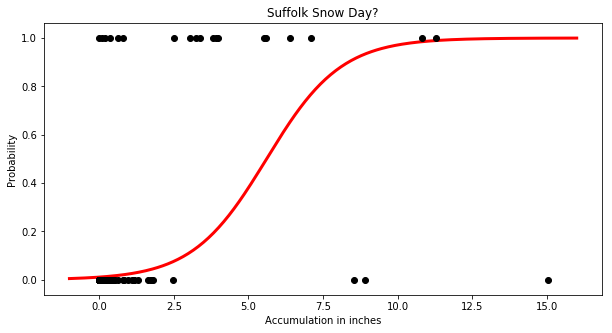

In [7]:
# I found this notebook useful in putting together this demo.
# http://nbviewer.jupyter.org/gist/justmarkham/6d5c061ca5aee67c4316471f8c2ae976

# Logistic Regression
y, X = dmatrices('closed ~ accum',joint_df, return_type="dataframe")
y = np.ravel(y)
model = LogisticRegression(fit_intercept = False, C = 1e9)
mdl = model.fit(X, y)

#print(X.head())
#print(y)

# I found this post useful in putting together the plot
# http://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic.html
plt.figure(1, figsize=(10, 5))
plt.clf()
plt.scatter(X["accum"], y, color='black', zorder=20)
X_test = np.linspace(-1, 16, 300) # left, right, points

def mod(x):
    return 1 / (1 + np.exp(-x))
loss = mod(X_test * mdl.coef_[0][1] + mdl.coef_[0][0])
plt.plot(X_test, loss, color='red', linewidth=3)

plt.xlabel('Accumulation in inches')
plt.ylabel('Probability')
plt.title('Suffolk Snow Day?')
plt.show()

In [8]:
# What percentage of the time was school closed?
print(y.mean())
# If I always said that there wouldn't be a snow day, how accurate would I be?
print(1-y.mean())

0.0199789695058
0.980021030494


In [12]:
# How accurate is this model?
#print(model.score(X, y))
#print ("")
evaluate(np.round_(model.predict_proba(X)[:,1]), y)

Accuracey: 0.981072555205

True Negatives: 929
False Positives: 3
False Negatives: 15
True Positives: 4
Recall: 0.571428571429
Precision: 0.210526315789
F1 Score: 0.307692307692


In [13]:
# Evaluate the model using cross-validation
# for more on cross-validation check out http://scikit-learn.org/stable/modules/cross_validation.html
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=5)
print ("Accuracy Scores (cv): %s"%scores)
print ("Average Accuracy (cv): %s"%scores.mean())


Accuracy Scores (cv): [ 0.97905759  0.97905759  0.98421053  0.98421053  0.98412698]
Average Accuracy (cv): 0.982132644001


In [10]:
# Prompt user for input and spit out a perdiction.

def closed():
    os.environ['amount'] = inputFunc('\nAccumulation of snow (inches)? ')
    if os.environ['amount'] != 'e':
        prob = model.predict_proba(np.array([[1,float(os.environ['amount'])]]))[0][1] # 1 and accum
        print("Probability of closure: %.2f %%"%(prob*100))
        closed()
        
print("Type `e` to exit, or interupt the kernel.")
closed()

Type `e` to exit, or interupt the kernel.

Accumulation of snow (inches)? e


# Can We Do Better? (Considering Other Factors)

In [ ]:
y, X_2 = dmatrices('closed ~ accum + temp_min + wind + past',joint_df, return_type="dataframe")
y = np.ravel(y)
model_2 = LogisticRegression(fit_intercept = False, C = 1e9)
mdl_2 = model_2.fit(X_2, y)

#print(X_2.head())

# check the accuracy
print ("First Model's Accuracy: %s"%model.score(X, y))
print ("This Model's Accuracy: %s"%model_2.score(X_2, y))

# evaluate the model using cross-validation
scores_2 = cross_val_score(LogisticRegression(), X_2, y, scoring='accuracy', cv=5)
print ("This Model's Accuracy Scores (cv): %s"%scores_2)
print ("This Model's Average Accuracy (cv): %s"%scores_2.mean())
print ("")
evaluate(np.round_(model_2.predict_proba(X_2)[:,1]), y)

def closed_2():
    os.environ['amount'] = inputFunc('\nAccumulation? ')
    if os.environ['amount'] != 'e':
        os.environ['low'] = inputFunc('Low temp? ')
        if os.environ['low'] != 'e':
            os.environ['wind'] = inputFunc('Wind speed? ')
            if os.environ['wind'] != 'e':
                os.environ['past'] = inputFunc('Closings in last 60 days? ')
                if os.environ['past'] != 'e':
                    prob = model_2.predict_proba(np.array([[1,float(os.environ['amount']),float(os.environ['low']),float(os.environ['wind']),float(os.environ['past'])]]))[0][1] # 1 and accum
                    print("Probability of closure: %.2f %%"%(prob*100))
                    closed_2()
        
print("\nType `e` to exit, or interupt the kernel.")
closed_2()